In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.linalg
from scipy.stats import zscore

inv = np.linalg.inv
norm = np.linalg.norm
sqrtm = scipy.linalg.sqrtm

Load data

In [2]:
X = np.load("X.npy")
driving = np.load("driving.npy")
series = np.load("series.npy")

In [3]:
[k, samples] = X.shape
m = 4

X_bar = X[:,0:samples-1] + X[:,1:samples]
X_dot = X[:,1:samples] - X[:,0:samples-1]

In [4]:
# this is what we want to recover
true_s_plot = zscore(driving[-5000 - m + 1:-m + 1])
# fix sign ambiguity
true_s_plot *= np.sign(true_s_plot[0])

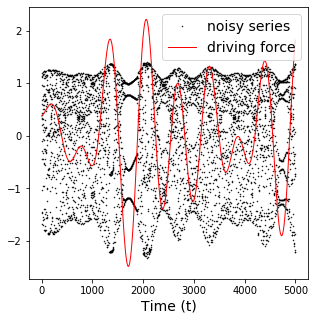

In [5]:
plt.figure(figsize=(5,5))
plt.plot(zscore(series[-5000:]), "k.", ms=1.0, label="noisy series")
plt.plot(zscore(true_s_plot), "r-", lw=1, label="driving force")
plt.xlabel("Time (t)", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("raw.pdf", transparent='true', bbox_inches='tight')

Compute GEVP solution

In [6]:
Cxx = np.cov(X)
Cxx_bar = np.cov(X_bar)
Cxx_dot = np.cov(X_dot)
Rxx = sqrtm(Cxx)

evals_bar, evecs_bar = scipy.linalg.eigh(Cxx_bar, Cxx)
evals_dot, evecs_dot = scipy.linalg.eigh(Cxx_dot, Cxx)

In [7]:
slow_gevp = evecs_dot[:,0]@X

np.save("gevp_solution", slow_gevp)

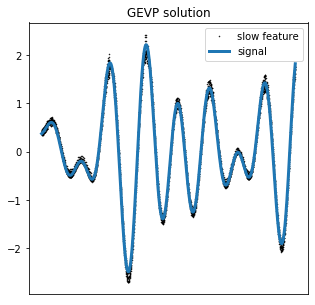

In [8]:
plt.figure(figsize=(5, 5))
# zscore to plot everyone together
plt.plot(zscore(slow_gevp[-5000:]*-1), "k.", ms=1.0, label="slow feature")
plt.plot(true_s_plot, lw=3, label="signal")
plt.xticks([])
plt.title("GEVP solution")
plt.legend()
plt.savefig("gevp_solution.png", dpi=300, transparent='true', bbox_inches='tight')

In [9]:
x_mean = np.mean(X, axis=1)

Parameters

In [10]:
trials = 10; iters = 5*10**7; a_list = [4]; b_list = [-4]; tau_list = [.5]; reportnum = 5; samples = X.shape[1]

In [11]:
approx_n_points = 1000
domain = list(sorted(set(map(int, np.round(np.logspace(0, np.log(iters-1), num=approx_n_points))))))
domain_len = len(domain)

Run online sfa

In [12]:
for log_a in a_list:
    
    a = 10**log_a
    
    for log_b in b_list:
        
        b = 10**log_b
        
        for tau in tau_list:

            slowness = np.zeros((trials,domain_len))
            error = np.zeros((trials,domain_len))
            constraint_error = np.zeros((trials,domain_len))
            runtime = np.zeros((trials,domain_len))
            
            print('a={}'.format(a),'b={}'.format(b),'tau={}'.format(tau))
            
            for n in range(trials):

                print('Trial {}:'.format(n+1))

                W = np.random.randn(1,k); W=W/norm(W)
                M = 1
                
                start_time = time.time()
                
                idx = np.random.permutation(iters)
                
                u = 0
                i = np.random.randint(0,samples)

                for t in range(iters):
                    
                    eta_t = 1/(a+b*t)

                    # input
                    
                    x = X[:,i] - x_mean
                    z = X_bar[:,i] - 2*x_mean

                    # neural dynamics

                    y = W@z/M

                    # synaptic updates

                    W = W + 2*eta_t*(np.outer(y,z) - W@np.outer(x,x))
                    M = M + (eta_t/tau)*(np.outer(y,y) - M)
                    
                    # update index
                    
                    i = (i+1)%(samples-1)

                    if t in domain:
                        V = W/M; V = inv(sqrtm(V@Cxx@V.T))@V
                        slowness[n,u] = V@Cxx_dot@V.T
                        error[n,u] = slowness[n,u] - evals_dot[0]
                        constraint_error[n,u] = abs(V@Cxx@V.T - 1)
                        runtime[n,u] = time.time() - start_time
                        u = u + 1

                    # output

                    if t%(iters//reportnum)==0:
                        V = W/M; V = inv(sqrtm(V@Cxx@V.T))@V
                        print('Sample {}:'.format(t))
                        print('run time: %s seconds' % (time.time() - start_time))
                        print('error:', V@Cxx_dot@V.T - evals_dot[0])

            # save data
            
            slow_online = W@X/M
    
            np.save(f"online_error/error_a={log_a}_b={log_b}_tau={tau}.npy", error)
            np.save(f"online_error/slowness_a={log_a}_b={log_b}_tau={tau}.npy", slowness)
            np.save(f"online_error/runtime_a={log_a}_b={log_b}_tau={tau}.npy", runtime)
            np.save("slow_feature_online", slow_online)
            np.save(f"online_error/constraint_error_a={log_a}_b={log_b}_tau={tau}.npy", constraint_error)

a=10000 b=0.0001 tau=0.5
Trial 1:
Sample 0:
run time: 3.17486310005188 seconds
error: [[1.60088643]]
Sample 10000000:
run time: 286.53873205184937 seconds
error: [[0.11116203]]
Sample 20000000:
run time: 565.295844078064 seconds
error: [[0.04219058]]
Sample 30000000:
run time: 846.6488151550293 seconds
error: [[0.01152427]]
Sample 40000000:
run time: 1128.2743389606476 seconds
error: [[0.00386059]]
Trial 2:
Sample 0:
run time: 3.114029884338379 seconds
error: [[2.30067393]]
Sample 10000000:
run time: 285.0986247062683 seconds
error: [[0.11305654]]
Sample 20000000:
run time: 574.6567778587341 seconds
error: [[0.04792086]]
Sample 30000000:
run time: 855.4212806224823 seconds
error: [[0.01551213]]
Sample 40000000:
run time: 1138.0240278244019 seconds
error: [[0.00450106]]
Trial 3:
Sample 0:
run time: 3.0923919677734375 seconds
error: [[2.15606055]]
Sample 10000000:
run time: 286.2581419944763 seconds
error: [[0.11949038]]
Sample 20000000:
run time: 570.703047990799 seconds
error: [[0.0544

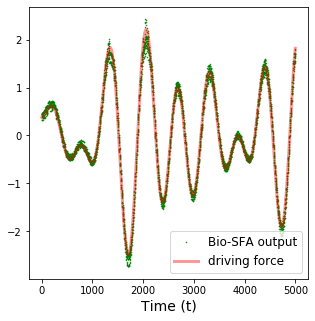

In [13]:
slow_online = np.load("slow_feature_online.npy")

plt.figure(figsize=(5, 5))
# zscore to plot everyone together
plt.plot(zscore(slow_online[0,-5000:]*-1), "g.", ms=1.0, label="Bio-SFA output")
plt.plot(true_s_plot, color="red", lw=3, label="driving force", alpha=0.4)
# plt.title("Online solution")
# plt.yticks([])
plt.xlabel("Time (t)", fontsize=14)
plt.legend(fontsize=12)
plt.savefig("online_solution.pdf", transparent='true', bbox_inches='tight')

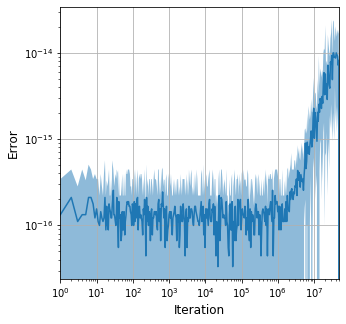

In [14]:
constraint_error = np.load("online_error/constraint_error_a=4_b=-4_tau=0.5.npy")

fig, ax = plt.subplots(figsize=(5,5))

ci = 90
delta = (100 - ci) / 2

mu = constraint_error.mean(axis=0)
ci_lo = np.percentile(constraint_error, delta, axis=0)
ci_hi = np.percentile(constraint_error, 100 - delta, axis=0)
ax.plot(domain, mu)
ax.fill_between(domain[:-1], ci_lo[0:len(domain)-1], ci_hi[0:len(domain)-1], alpha=.5)

ax.loglog()
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.xlim(1,iters)
# plt.ylim(5*10**-3,1)
plt.grid()

# plt.savefig("chaotic_error_oja.pdf", transparent='true', bbox_inches='tight')